In [1]:
import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import u_net as unet
import skimage.io
import keras.backend as K

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# Keras related
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Progress bar
from tqdm import tqdm

import random
import warnings

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128*2
IMG_HEIGHT = 128*2
IMG_CHANNELS = 3
TRAIN_PATH = 'data/'
TEST_PATH = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
import os
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
import sys
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# # Get and resize test images
# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:14<00:00,  9.45it/s]


Done!


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


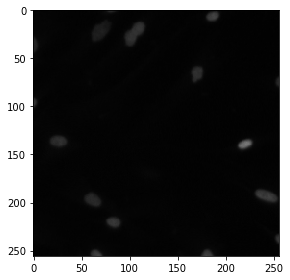

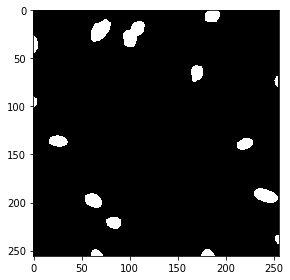

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
# Rescale the data
X_train = X_train.astype(float)/255
print(X_train.shape)
print(Y_train.shape)
print(X_train[0])

(670, 256, 256, 3)
(670, 256, 256, 1)
[[[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.00784314 0.00784314 0.00784314]]

 [[0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]
  [0.00784314 0.00784314 0.00784314]]

 [[0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.01568627 0.01568627 0.01568627]
  [0.01176471 0.01176471 0.01176471]
  [0.00784314 0.00784314 0.00784314]]

 ...

 [[0.00784314 0.00784314 0.00784314]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.00784314 0.00784314 0.00784314]

In [17]:
def swish(x):
    return x*K.sigmoid(x)

def e_swish(x):
    return 1.375*x*K.sigmoid(x)

# model = unet.u_net(start=16, act="elu")
# model.summary()
import keras
import numpy as np 
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Activation, Add, Concatenate, Dense
from keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose

# Design our model architecture here
def keras_model(input_shape=(256,256,3)):
    inputs = Input(shape=input_shape)
    
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = Concatenate(axis=3)([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = Concatenate(axis=3)([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = Concatenate(axis=3)([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = keras_model()

In [18]:
loss      = unet.bce_dice_loss
metrics   = [unet.mean_iou, unet.dice_coef]
# Compile the model
model.compile(optimizer='adam', loss=loss, metrics=metrics)

In [19]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=5, verbose=2) # callbacks=[earlystopper, checkpointer], 

Train on 603 samples, validate on 67 samples
Epoch 1/5
 - 20s - loss: -5.7456e-01 - mean_iou: 0.6292 - dice_coef: 0.7005 - val_loss: -6.7720e-01 - val_mean_iou: 0.7365 - val_dice_coef: 0.7806
Epoch 2/5
 - 18s - loss: -7.6613e-01 - mean_iou: 0.7663 - dice_coef: 0.8383 - val_loss: -7.5486e-01 - val_mean_iou: 0.7885 - val_dice_coef: 0.8330
Epoch 3/5
 - 18s - loss: -8.0482e-01 - mean_iou: 0.8025 - dice_coef: 0.8651 - val_loss: -7.9428e-01 - val_mean_iou: 0.8141 - val_dice_coef: 0.8612
Epoch 4/5
 - 18s - loss: -8.1583e-01 - mean_iou: 0.8218 - dice_coef: 0.8726 - val_loss: -7.8872e-01 - val_mean_iou: 0.8289 - val_dice_coef: 0.8620
Epoch 5/5
 - 18s - loss: -8.2245e-01 - mean_iou: 0.8344 - dice_coef: 0.8784 - val_loss: -7.7302e-01 - val_mean_iou: 0.8383 - val_dice_coef: 0.8443


In [20]:
# Predict on train set
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)

603/603 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 7ms/step


c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


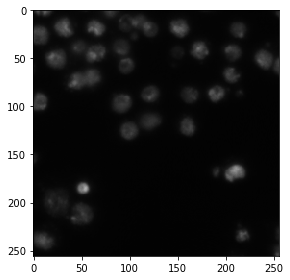

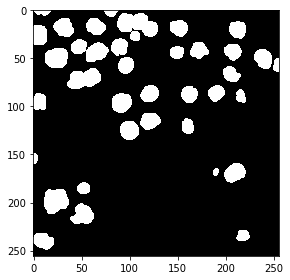

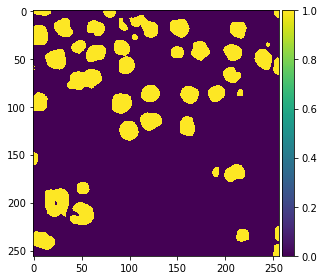

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()